In [1]:
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import os
import torch
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from SNN import FeedForward, SiameseDataSet, SiameseModel, seed_everything
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
from sklearn.datasets import make_circles

np.random.seed(42)

X, y = make_circles(n_samples=4000, factor=.3, noise=0.05)
OneHot = OneHotEncoder(sparse=False)
y = OneHot.fit_transform(y.reshape((y.shape[0], 1)))

In [3]:
y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [4]:
y.shape

(4000, 2)

In [5]:
np.sum(y, axis=0)

array([2000., 2000.])

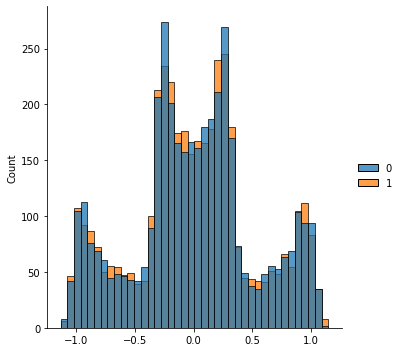

In [6]:
sns.displot(X)

In [7]:
# Test Effect of making X non-negative
# X = X + 2

# Define and Train Model

In [8]:
seed_everything(69)

In [9]:
MyFeedForward = FeedForward(2, [6, 6, 3, 3, 2], activation='relu')

In [10]:
MyFeedForward

FeedForward(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): Linear(in_features=6, out_features=6, bias=True)
    (2): Linear(in_features=6, out_features=3, bias=True)
    (3): Linear(in_features=3, out_features=3, bias=True)
    (4): Linear(in_features=3, out_features=2, bias=True)
  )
)

In [11]:
MySNN = SiameseModel(MyFeedForward, predict_unknown = False, class_min_train=5, 
                     n_example_predict=10, learning_rate=1.0e-3, num_epochs = 50, batch_size = 1000, rand_seed=142)

In [12]:
# list(MySNN.logistic.parameters()) + list(MySNN.model.parameters())

In [13]:
MyTrainer = Trainer(model = MySNN, scale_X = False, use_pca = False, n_components = 2)

In [14]:
MyTrainTester = TrainTester(MyTrainer, metrics.accuracy_score)

In [15]:
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, n_splits=n_splits)

In [ ]:
MyMultiTrainTester.train(X, y)

Running for split 1 of 5
Training Encoder
#########################################
Epoch 1 of 50
__Training__
2021-03-09 02:31:06
MEAN LOSS: 0.718445248413086
__Validation__
2021-03-09 02:31:07
MEAN LOSS: 0.7144462248959271
#########################################
Epoch 2 of 50
__Training__
2021-03-09 02:31:07
MEAN LOSS: 0.7142384643554688
__Validation__
2021-03-09 02:31:07
MEAN LOSS: 0.7106706840728018
#########################################
Epoch 3 of 50
__Training__
2021-03-09 02:31:07
MEAN LOSS: 0.7105476470947265
__Validation__
2021-03-09 02:31:08
MEAN LOSS: 0.7074052894791433
#########################################
Epoch 4 of 50
__Training__
2021-03-09 02:31:08
MEAN LOSS: 0.7073629486083984
__Validation__
2021-03-09 02:31:08
MEAN LOSS: 0.7046190977740352
#########################################
Epoch 5 of 50
__Training__
2021-03-09 02:31:08
MEAN LOSS: 0.704646011352539
__Validation__
2021-03-09 02:31:09
MEAN LOSS: 0.7022686674184997
########################################

In [ ]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

In [ ]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [ ]:
MyMultiTrainTester.plot_class_freq(normalize=True)

In [ ]:
MyMultiTrainTester.plot_confusion(normalize=True)

In [ ]:
for i, trainer in enumerate(MyMultiTrainTester.TrainerList):
    plt.figure(i)
    print(sns.lineplot(data=trainer.model.TrainStats, x='epoch', y='mean_loss', hue = 'stage'))

### Examine Data In Encoded Space

In [ ]:
Trainer_use = MyMultiTrainTester.TrainerList[0]

In [ ]:
X_transform = Trainer_use.transform_X(X)

In [ ]:
X_encoded = Trainer_use.model.model.forward(torch.from_numpy(X_transform).to(torch.float32)).detach().numpy()

In [ ]:
# X_encoded = MyFeedForward.forward(torch.from_numpy(X_transform).to(torch.float32)).detach().numpy()

In [ ]:
X_encoded.shape

In [ ]:
y_label = Trainer_use.model.one_hot.inverse_transform(y).astype('str')

In [ ]:
y_pred = Trainer_use.model.predict(X_transform)
y_pred = Trainer_use.model.one_hot.inverse_transform(y_pred).astype('str')

In [ ]:
X_enc_df = pd.DataFrame(X_encoded, columns = ['X' + str(i+1) for i in range(X_encoded.shape[1])])
X_enc_df['y'] = y_label
X_enc_df['y_pred'] = y_pred

In [ ]:
X_enc_df

In [ ]:
sns.displot(data=X_enc_df, x='X1', hue='y')

In [ ]:
sns.displot(data=X_enc_df, x='X2', hue='y')

In [ ]:
def do_plot(df, x, y, hue):
    if x in df.columns and y in df.columns and hue in df.columns:
        sns.scatterplot(data=df, x=x, y=y, hue = hue)

In [ ]:
do_plot(X_enc_df, 'X1', 'X2', 'y')

In [ ]:
do_plot(X_enc_df, 'X1', 'X2', 'y_pred')

In [ ]:
do_plot(X_enc_df, 'X2', 'X3', 'y')

In [ ]:
do_plot(X_enc_df, 'X3', 'X4', 'y')

### Examine Misclassified Samples, or first sample if no misclassified samples

If no misclassified samples, show correcly classified sample

In [ ]:
X_db = Trainer_use.model.ClassDB['X_encoded'].detach().numpy()
X_db.shape

In [ ]:
y_db = Trainer_use.model.ClassDB['y'].detach().numpy()
y_db = Trainer_use.model.one_hot.inverse_transform(y_db).astype('str').flatten()

In [ ]:
db_df = pd.DataFrame(X_db, columns = ['X' + str(i+1) for i in range(X_encoded.shape[1])])
db_df['y'] = y_db

In [ ]:
db_df['y'].value_counts()

In [ ]:
do_plot(db_df, 'X1', 'X2', 'y')

In [ ]:
do_plot(db_df, 'X2', 'X3', 'y')

In [ ]:
X_enc_df['misclassified'] = X_enc_df['y'] != X_enc_df['y_pred']

In [ ]:
X_enc_df

In [ ]:
misclassified_idx = np.argwhere(X_enc_df['misclassified'].to_numpy()).flatten()
misclassified_idx

In [ ]:
if len(misclassified_idx) == 0:
    X_diff = torch.abs(torch.from_numpy(X_encoded[0, :] - X_db).to(torch.float32))
else:
    X_diff = torch.abs(torch.from_numpy(X_encoded[misclassified_idx[0], :] - X_db).to(torch.float32))
logistic_output = Trainer_use.model.logistic.forward(X_diff)

In [ ]:
logistic_output[y_db == '0', 1]

In [ ]:
# distribution of 0 label probabilities
sns.displot(logistic_output[y_db == '0', 1].detach().numpy())

In [ ]:
# distribution of 1 label probabilities
sns.displot(logistic_output[y_db == '1', 1].detach().numpy())

In [ ]:
torch.median(logistic_output[y_db == '0',1])

In [ ]:
torch.median(logistic_output[y_db == '1',1])

In [ ]:
X_diff_df = pd.DataFrame(X_diff, columns = ['X' + str(i+1) + '_diff' for i in range(X_encoded.shape[1])])
X_diff_df['y'] = y_db

In [ ]:
do_plot(X_diff_df, 'X1_diff', 'X2_diff', 'y')

In [ ]:
do_plot(X_diff_df, 'X2_diff', 'X3_diff', 'y')

In [ ]:
for p in Trainer_use.model.logistic.parameters():
    print(p)

### Examine Data In Original Space

In [ ]:
X_df = pd.DataFrame(X, columns = ['X1', 'X2'])
X_df['y'] = y_label

In [ ]:
sns.scatterplot(data=X_df, x='X1', y='X2', hue = 'y')